In [23]:
#Importar Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
#Valores Fijos

# Parámetros físicos
c = 343  # velocidad del sonido (m/s)
rho0 = 1.2  # densidad del aire
q0 = 1  # fuerza de la fuente
p0 = 2e-5  # presión de referencia (Pa)

In [25]:
# Ingresar las dimensiones de la sala
Lx, Ly, Lz = 4.11, 5.86, 2.49
V = Lx * Ly * Lz

In [30]:
# Posición de la fuente arbitraria
x0 = np.array([2, 3, 1])

# Posiciones de los micrófonos
mic_locs = np.array([
    [2.0, 5.0, 1.5],
    [1.0, 2.0, 1.5],
    [3.0, 4.0, 1.5]
])

In [31]:
# Cargar modos desde CSV
df = pd.read_csv("modos_sala.csv")

#Cambiar valores de Lambda según el tipo de modo
tipo_to_lambda = {
    'axial': 1/2,
    'tangencial': 1/4,
    'oblicuo': 1/8
}
df['Lambda'] = df['tipo'].map(tipo_to_lambda) #Realizar el cambio en el DataFrame

In [32]:
# Rango de frecuencias para el calculo
freqs = np.linspace(20, 300, 500)
omega = 2 * np.pi * freqs # Arreglo de W para cada frecuencia
k0_array = omega / c #Arreglo de numeros de onda

# Inicializar matriz de presión para cada mic y cada frecuencia
Lp_all = np.zeros((len(mic_locs), len(freqs)))

# Función base PSI para agilizar calculo
def psi(n, x, L):
    return np.cos(n * np.pi * x / L)

# Cálculo
for mi, xr in enumerate(mic_locs): # Por cada micrófono

    for fi, f in enumerate(freqs): # Por cada frecuencia en el rango
        k0 = k0_array[fi]
        w = omega[fi]
        p = 0  # reiniciar presión para esta frecuencia

        for _, row in df.iterrows(): # 
            nx, ny, nz = int(row['nx']), int(row['ny']), int(row['nz'])
            f_m = row['frecuencia']
            Lambda = row['Lambda']

            # Coordenadas espaciales
            psi_r = psi(nx, xr[0], Lx) * psi(ny, xr[1], Ly) * psi(nz, xr[2], Lz)
            psi_s = psi(nx, x0[0], Lx) * psi(ny, x0[1], Ly) * psi(nz, x0[2], Lz)

            # Número de onda modal
            k_m = 2 * np.pi * f_m / c

            # Término modal
            denom = (k0**2 - k_m**2) * Lambda
            if np.abs(denom) > 1e-10:
                p += psi_r * psi_s / denom

        # Constante y Calculo de SPL
        p *= -1j * w * q0 / V
        Lp_all[mi, fi] = 20 * np.log10(np.abs(p) / p0)

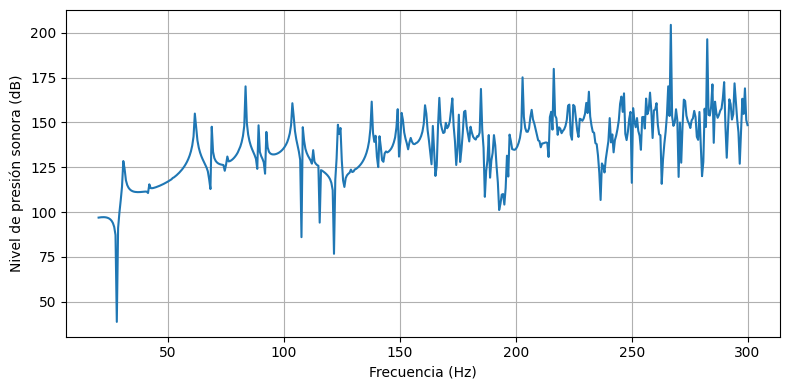

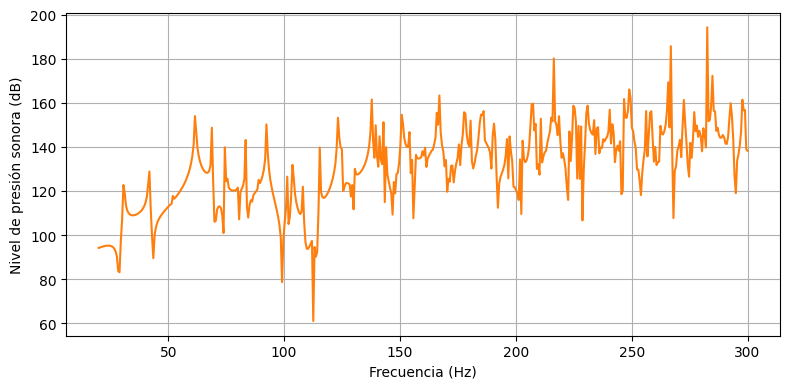

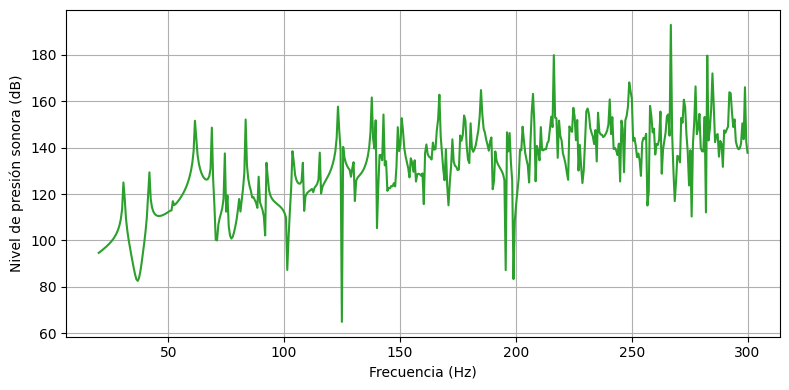

In [33]:
# Graficar
for i in range(len(mic_locs)):
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, Lp_all[i], color='C'+str(i))
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Nivel de presión sonora (dB)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()